In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings

In [2]:
from jupyterthemes import jtplot

# from ali.ali_sw import *
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_bg import *
from xps.xps_analysis import *

jtplot.style('default', grid=False)

## Pre process bulk file

In [ ]:
#L Pt_No  energy_mono_corrected  ideu71_motor_gap  adc2_timer  adc2_i1  adc2_i2  adc2_i3  adc2_i4  timer_mono_ct  energy_mono_ct  grpitch_mono_ct  grenc_mono_ct  dt
...
#C Acquisition ended at Thu Mar 12 12:59:26 2020

In [10]:
path = '/Users/pabloherrero/sabat/nexafs_data/IHR_CeliaMaxim_10Mar2020.dat'

In [11]:
def dat_region_delimiters(path: str) -> tuple:
    """Retrieve position, name and number of lines of each spectrum in a .dat file"""

    skipRows0 = []
    nrows0 = []
    filenames = []

    with open(path) as infile:
        for i,line in enumerate(infile):
            if '#L Pt_No' in line:
                skipRows0.append(i)
#             try:
#             except AttributeError:
#                 pass
            if '#S ' in line:
                nrows0.append(i)
                re.match('#S \d+', line).group()
                name = '_'.join(line.split()[:4])
                filename = os.path.join(os.path.split(path)[0], name)+'.dat'     
                filenames.append(filename)
                
    return (skipRows0, nrows0, filenames)

In [5]:
def test_dat_region_delimiters(path):
    skipRows, nrows, names = dat_region_delimiters(path)
    assert len(skipRows) == len(nrows), "len(skiprows) and len(nrows) don't coincide"
    assert len(skipRows) == len(names), "len(skiprows) and len(names) don't coincide"

In [7]:
def load_nexafs_file(fileid : int):
    nrows0 = nrows[fileid+1] - nrows[fileid] - skipRows[0] - 3
    df = pd.read_csv(filenames[fileid], sep='\s+', skiprows=skipRows[0], nrows=nrows0, engine='python', index_col=0)
    cols = df.columns.values[1:]
    df.drop('dt', axis=1, inplace=True)
    df.columns = cols
    for i in range(1,5):
        df.rename(columns={'adc2_i'+str(i):'i'+str(i)}, inplace=True)
        
    return df

In [17]:
def plot_dichroism(exps : list, thres : float, ithres : int = 0):
    """Divide files over two polarizations using a hard threshold
    average each, subtract and plot all"""
    A = []
    B = []
    for i,xp in enumerate(exps):
        if (xp.i3/xp.i2).iloc[ithres] > thres:
            A.append(xp.i3/xp.i2)
        else:
            B.append(xp.i3/xp.i2)
    #     (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 125), figsize=(10,8))
    avgA = pd.concat(A, axis=1).mean(axis=1)
    avgB = pd.concat(B, axis=1).mean(axis=1)
    avgA.index = exps[0]['energy_mono_ct']
    avgB.index = exps[0]['energy_mono_ct']

    fig, ax = plt.subplots(figsize=(12,8))
    avgA.plot(ax=ax, label='avgA')
    avgB.plot(ax=ax, label='avgB')

    ax2 = ax.twinx()
    (avgB-avgA).plot(ax=ax2, label='Dichroism', color='r', alpha=0.2)

    fig.legend()
    return avgA, avgB

In [12]:
test_dat_region_delimiters(path)

In [13]:
skipRows, nrows, filenames = dat_region_delimiters(path)
filenames[0], nrows[:2]

('/Users/pabloherrero/sabat/nexafs_data/#S_1_ascanct_dummy_mot01.dat',
 [0, 145])

# Split files

In [4]:
def split_files(path):
    skipRows, nrows, filenames = dat_region_delimiters(path)
    with open(path) as infile:
        for nr, nr1, fname in zip(nrows[:-1], nrows[1:], filenames):
    #         print(nr, nr1, fname)
    #         if nr == 489:
    #             break
    #         else:
            chunk = [next(infile) for i in range(nr,nr1)]
    #         print(chunk[-2])
            with open(fname, 'w') as fout:
                for line in chunk:
                    fout.write(line)

In [216]:
split_files(path)

# Read file[0]

In [231]:
nrows[1]-skipRows[0]-3

101

In [232]:
nrows[2]-nrows[1]-skipRows[0]-3

81

In [238]:
filenames[0]
df0 = pd.read_csv(filenames[0], sep='\s+', skiprows=skipRows[0], nrows=101, engine='python', index_col=0)
df0

,Pt_No,dummy_mot01,adc2_timer,adc2_i1,adc2_i2,adc2_i3,adc2_i4,timer_mono_ct,energy_mono_ct,grpitch_mono_ct,grenc_mono_ct,dt
#L,,,,,,,,,,,,
0,0.0,0.01,-0.001939,-0.127144,-0.002367,-0.001825,0.01,778.553494,-5877.534557,1593168.0,0.001000,NaN
1,1.0,0.01,-0.001788,-0.127032,-0.001788,-0.001775,0.01,778.549617,-5877.607285,1593171.0,0.011003,NaN
2,2.0,0.01,-0.001808,-0.127173,-0.001654,-0.001912,0.01,778.553494,-5877.534557,1593168.0,0.021005,NaN
3,3.0,0.01,-0.001900,-0.127132,-0.001897,-0.001788,0.01,778.553494,-5877.534557,1593168.0,0.031008,NaN
4,4.0,0.01,-0.001843,-0.127165,-0.001868,-0.001849,0.01,778.553494,-5877.534557,1593168.0,0.041010,NaN
5,5.0,0.01,-0.001828,-0.127084,-0.001917,-0.001842,0.01,778.550909,-5877.583042,1593170.0,0.051013,NaN
6,6.0,0.01,-0.001768,-0.126970,-0.001878,-0.001799,0.01,778.553494,-5877.534557,1593168.0,0.061015,NaN
7,7.0,0.01,-0.001817,-0.127051,-0.001958,-0.001912,0.01,778.552202,-5877.558799,1593169.0,0.071017,NaN
8,8.0,0.01,-0.001891,-0.126949,-0.001897,-0.001755,0.01,778.550909,-5877.583042,1593170.0,0.081020,NaN


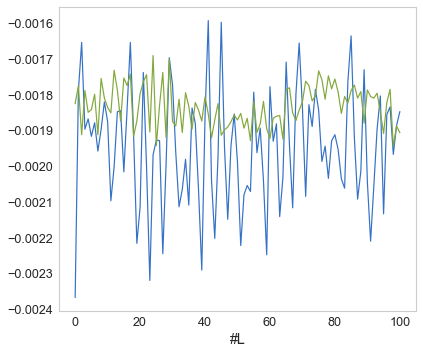

In [241]:
# df0.adc2_i1.plot()
df0.adc2_i2.plot()
df0.adc2_i3.plot()

In [230]:
nrows0 = nrows[2]-nrows[1]-skipRows[0]-3
df0 = pd.read_csv(filenames[1], sep='\s+', skiprows=skipRows[0], nrows=nrows0, engine='python', index_col=0)# dtype=float)
df0

,Pt_No,tm_roll,adc2_timer,adc2_i1,adc2_i2,adc2_i3,adc2_i4,energy_mono_encoder,gr_pitch_renaverage_enc,dt
#L,,,,,,,,,,
0,-6972.628421,0.1,-0.002208,-0.004265,-0.001869,-0.001512,778.682421,1.593068e+06,1.662366,NaN
1,-6956.130484,0.1,-0.002288,-0.005799,-0.001917,-0.001503,778.679605,1.593070e+06,2.586406,NaN
2,-6953.505812,0.1,-0.002312,-0.006262,-0.001911,-0.001503,778.682227,1.593068e+06,3.441927,NaN
3,-6951.256093,0.1,-0.002348,-0.006726,-0.001956,-0.001509,778.682744,1.593068e+06,4.305300,NaN
4,-6948.631421,0.1,-0.002364,-0.007108,-0.001933,-0.001547,778.682744,1.593068e+06,5.092129,NaN
5,-6946.006749,0.1,-0.002370,-0.007531,-0.001955,-0.001511,778.682098,1.593068e+06,5.851944,NaN
6,-6943.007124,0.1,-0.002433,-0.008214,-0.001947,-0.001535,778.681236,1.593069e+06,6.729407,NaN
7,-6941.132358,0.1,-0.002425,-0.008763,-0.001923,-0.001532,778.681451,1.593069e+06,7.567374,NaN
8,-6938.507687,0.1,-0.002491,-0.009400,-0.001935,-0.001558,778.681710,1.593069e+06,8.375074,NaN


In [7]:
def load_nexafs_file(fileid : int):
    nrows0 = nrows[fileid+1] - nrows[fileid] - skipRows[0] - 3
    df = pd.read_csv(filenames[fileid], sep='\s+', skiprows=skipRows[0], nrows=nrows0, engine='python', index_col=0)
    cols = df.columns.values[1:]
    df.drop('dt', axis=1, inplace=True)
    df.columns = cols
    for i in range(1,5):
        df.rename(columns={'adc2_i'+str(i):'i'+str(i)}, inplace=True)
        
    return df

In [14]:
df10 = load_nexafs_file(10)
df10.set_index('energy_mono_ct', inplace=True)
for i in range(1,5):
    print(i)
    df10.rename(columns={'adc2_i'+str(i):'i'+str(i)}, inplace=True)
df10

1
2
3
4


,energy_mono_corrected,ideu71_motor_gap,adc2_timer,i1,i2,i3,i4,timer_mono_ct,grpitch_mono_ct,grenc_mono_ct,dt
energy_mono_ct,,,,,,,,,,,
514.949519,515.00,31437.929035,0.1,-0.222472,-0.518273,-0.364731,-0.001615,0.1,-13354.461491,1901589.0,0.299811
514.986829,515.05,31439.272955,0.1,-0.222641,-0.518620,-0.367353,-0.001627,0.1,-13352.861480,1901523.0,0.399847
515.028668,515.10,31440.616875,0.1,-0.222605,-0.518419,-0.366796,-0.001610,0.1,-13351.067527,1901449.0,0.499883
515.072776,515.15,31441.960795,0.1,-0.222271,-0.517583,-0.365384,-0.001607,0.1,-13349.176605,1901371.0,0.599920
515.118589,515.20,31443.304714,0.1,-0.222143,-0.516858,-0.365219,-0.001605,0.1,-13347.212954,1901290.0,0.699956
515.166107,515.25,31444.648634,0.1,-0.221897,-0.516090,-0.366644,-0.001630,0.1,-13345.176576,1901206.0,0.799992
515.208541,515.30,31445.992554,0.1,-0.221948,-0.516033,-0.365115,-0.001635,0.1,-13343.358381,1901131.0,0.900028
515.254377,515.35,31447.336474,0.1,-0.222115,-0.516399,-0.366334,-0.001648,0.1,-13341.394730,1901050.0,1.000065
515.302486,515.40,31448.680394,0.1,-0.222546,-0.517672,-0.365226,-0.001641,0.1,-13339.334109,1900965.0,1.100101


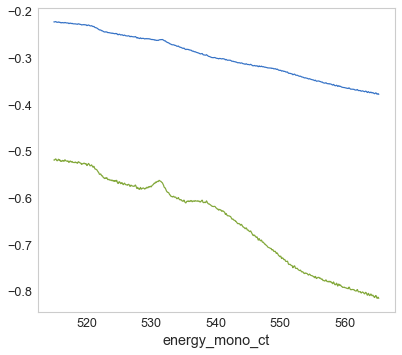

In [16]:
df10.i1.plot()
df10.i2.plot()
# df10.adc2_i3.plot()
# plt.xlim(510, 570)

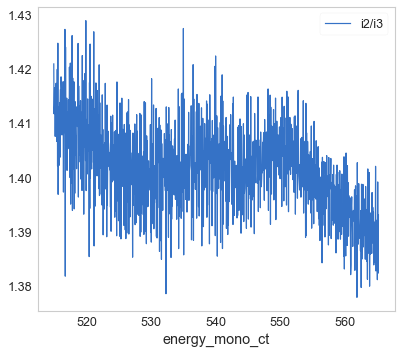

In [307]:
(df10.i2/df10.i3).plot(label='i2/i3')
plt.legend()

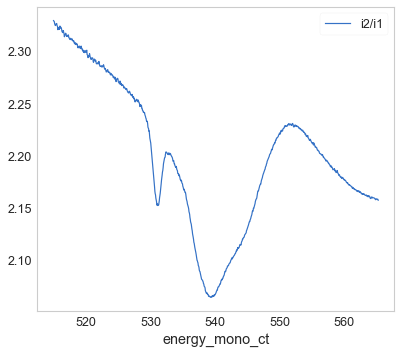

In [308]:
(df10.i2/df10.i1).plot(label='i2/i1')
plt.legend()

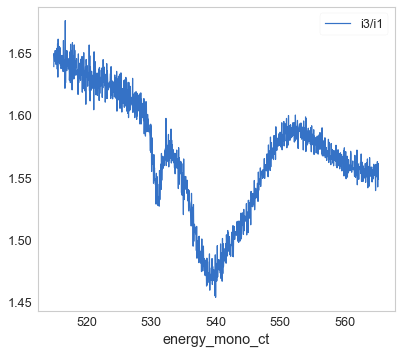

In [309]:
(df10.i3/df10.i1).plot(label='i3/i1')
plt.legend()

## Exp 15-18

In [365]:
exps = [load_nexafs_file(i) for i in range(15,19)]

In [344]:
exps[3]

,energy_mono_corrected,adc2_timer,i1,i2,i3,i4,adc3_i3,energy_mono_encoder,gr_pitch_renaverage_enc,hectorfieldy,dt
#L,,,,,,,,,,,
0,848.000774,0.1,-3.547931,-6.951059,-4.322282,-0.002198,0.211161,847.982792,1.543841e+06,5.995439,2.401784
1,852.000530,0.1,-3.445751,-6.670251,-4.805535,-0.002232,0.209939,852.008402,1.541228e+06,5.988471,3.887622
2,848.000774,0.1,-3.572223,-6.883293,-4.322970,-0.002258,0.206966,847.981259,1.543842e+06,5.953179,7.306332
3,852.000530,0.1,-3.469936,-6.607700,-4.803694,-0.002256,0.205675,852.003095,1.541231e+06,5.901985,8.862094
4,848.000774,0.1,-3.598068,-6.814682,-4.324056,-0.002156,0.202666,847.969843,1.543850e+06,5.847756,12.393950
5,852.000530,0.1,-3.486296,-6.517387,-4.793128,-0.002102,0.201229,852.015521,1.541223e+06,5.810666,13.995138
6,848.000774,0.1,-3.616292,-6.737714,-4.314735,-0.001940,0.198469,847.991689,1.543836e+06,5.722944,17.332453
7,852.000530,0.1,-3.509897,-6.468080,-4.785076,-0.001861,0.197198,852.000000,1.541233e+06,5.699904,18.760184
8,848.000774,0.1,-3.644489,-6.696519,-4.319993,-0.001607,0.194286,847.982874,1.543841e+06,5.616397,22.148052


In [351]:
for xp in exps[:3]:
    xp.set_index('energy_mono_ct', inplace=True)

exps[0]

,energy_mono_corrected,ideu71_motor_gap,adc2_timer,i1,i2,i3,i4,timer_mono_ct,grpitch_mono_ct,grenc_mono_ct,dt
energy_mono_ct,,,,,,,,,,,
834.874505,835.00,46321.326031,0.05,-3.545700,-7.181013,-4.452598,-0.002188,0.05,-4892.266808,1552526.0,0.299811
834.908685,835.05,46323.297389,0.05,-3.545746,-7.180854,-4.452371,-0.002195,0.05,-4891.709228,1552503.0,0.349835
834.950300,835.10,46325.268748,0.05,-3.545690,-7.179264,-4.451454,-0.002188,0.05,-4891.030435,1552475.0,0.399859
834.996378,835.15,46327.240106,0.05,-3.545008,-7.176029,-4.450082,-0.002166,0.05,-4890.278914,1552444.0,0.449884
835.036515,835.20,46329.211464,0.05,-3.543899,-7.172057,-4.448036,-0.002166,0.05,-4889.624364,1552417.0,0.499908
835.081116,835.25,46331.182823,0.05,-3.541906,-7.165550,-4.444060,-0.002194,0.05,-4888.897086,1552387.0,0.549932
835.122748,835.30,46333.154181,0.05,-3.540673,-7.161600,-4.441735,-0.002183,0.05,-4888.218293,1552359.0,0.599956
835.168845,835.35,46335.125539,0.05,-3.540284,-7.160276,-4.440986,-0.002167,0.05,-4887.466773,1552328.0,0.649981
835.214947,835.40,46337.096898,0.05,-3.539777,-7.158606,-4.439990,-0.002167,0.05,-4886.715252,1552297.0,0.700005


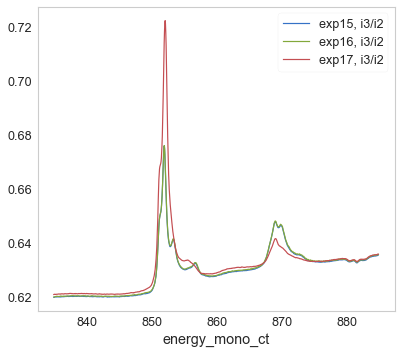

In [355]:
for i,xp in enumerate(exps[:3]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 15))
plt.legend()

In [370]:
try:
    exps[3].set_index('energy_mono_ct', inplace=True)
except KeyError:
    exps[3].set_index('energy_mono_corrected', inplace=True)
    
    

# FBI

## O 

In [366]:
xpO[0]

,energy_mono_corrected,ideu71_motor_gap,adc2_timer,i1,i2,i3,i4,timer_mono_ct,energy_mono_ct,grpitch_mono_ct,grenc_mono_ct,dt
#L,,,,,,,,,,,,
0,270.00,24101.423518,0.1,-0.512847,-4.096170,-1.653731,-0.001883,0.1,270.214906,-1792.704507,1422195.0,0.299811
1,270.05,24103.139444,0.1,-0.513712,-4.103463,-1.654347,-0.001900,0.1,270.242931,-1791.613590,1422150.0,0.399896
2,270.10,24104.855370,0.1,-0.513517,-4.100009,-1.653376,-0.001888,0.1,270.276568,-1790.304490,1422096.0,0.499981
3,270.15,24106.571297,0.1,-0.513064,-4.091047,-1.651950,-0.001908,0.1,270.314576,-1788.825691,1422035.0,0.600066
4,270.20,24108.287223,0.1,-0.512879,-4.082623,-1.645095,-0.001897,0.1,270.350101,-1787.443863,1421978.0,0.700151
5,270.25,24110.003149,0.1,-0.512876,-4.075750,-1.642634,-0.001918,0.1,270.386259,-1786.037792,1421920.0,0.800236
6,270.30,24111.719075,0.1,-0.512664,-4.067305,-1.637054,-0.001912,0.1,270.424298,-1784.558993,1421859.0,0.900321
7,270.35,24113.435001,0.1,-0.512424,-4.060287,-1.636065,-0.001937,0.1,270.466090,-1782.934739,1421792.0,1.000406
8,270.40,24115.150928,0.1,-0.511854,-4.050928,-1.632069,-0.001928,0.1,270.502279,-1781.528668,1421734.0,1.100492


In [ ]:
xpO = [load_nexafs_file(i) for i in range(125,136)]
for i,xp in enumerate(xpO[:]):
    try:
        xp.set_index('energy_mono_ct', inplace=True)
    except KeyError:
        xp.set_index('energy_mono_corrected', inplace=True)

# NiBr2/NbSe2

## O

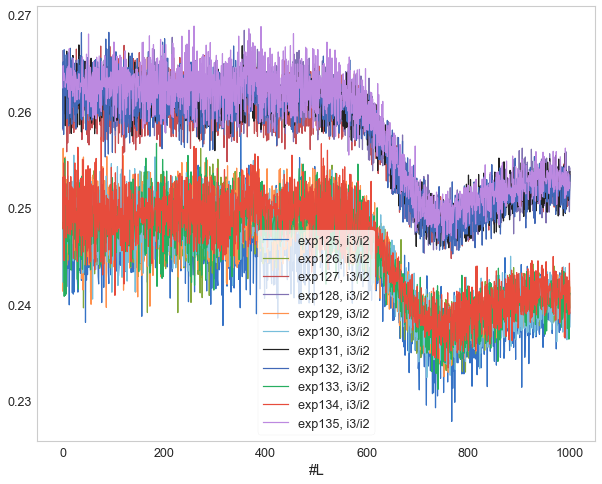

In [569]:
xpO = [load_nexafs_file(i) for i in range(125,136)]
for i,xp in enumerate(xpO[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 125), figsize=(10,8))
plt.legend()

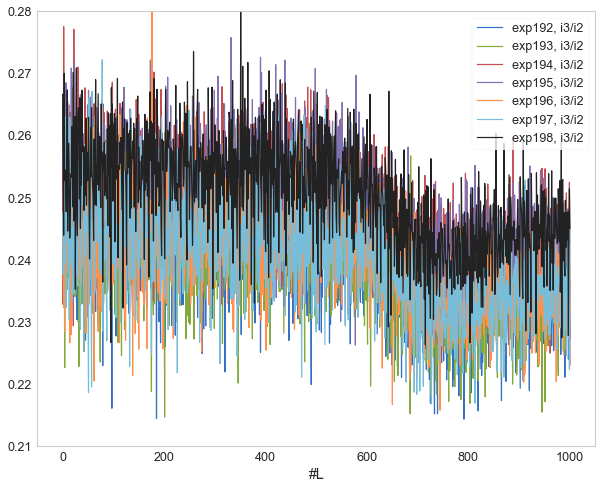

In [570]:
xpOba = [load_nexafs_file(i) for i in range(192,199)]
for i,xp in enumerate(xpOba[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 192), figsize=(10,8))
plt.ylim(0.21,0.28)
plt.legend()

Text(0.5, 0.98, 'Oxigen XLD, (no FBI deposited) on NiBr2/NbSe2')

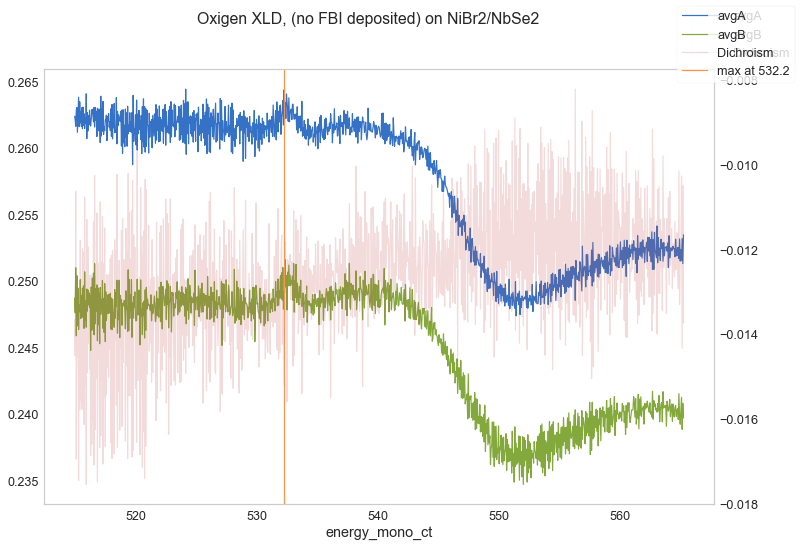

In [102]:
xpOfbi = [load_nexafs_file(i) for i in range(125,136)]
ava, avb = plot_dichroism(xpOfbi, thres=0.255, ithres=0)
# plt.axvline(ava.idxmax(), label='max at %.1f'%ava.idxmax(), color='k')

idmax = np.where(ava == ava.max())[0][0]
max2 = ava.iloc[idmax+70:].idxmax()
plt.axvline(max2, label='max at %.1f'%max2, color='y')

plt.gcf().legend()
plt.gcf().suptitle('Oxigen XLD, (no FBI deposited) on NiBr2/NbSe2')

Text(0.5, 0.98, 'FBI-Ba, Oxigen')

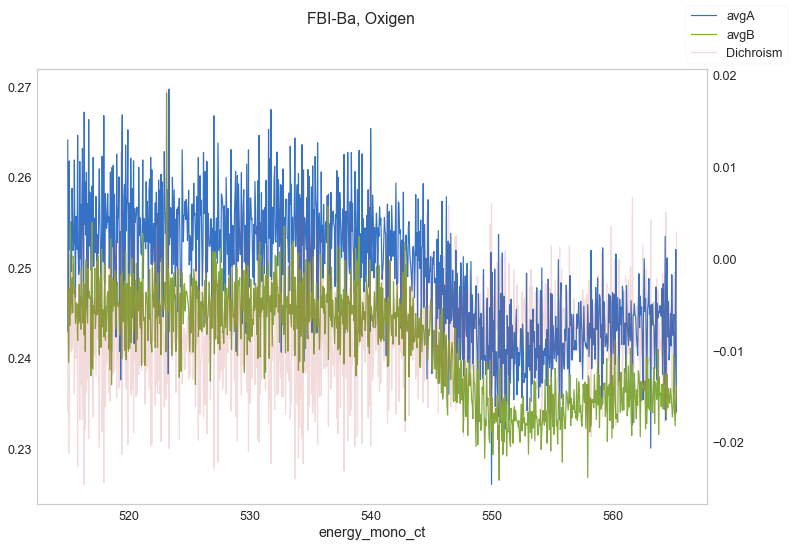

In [572]:
plot_dichroism(xpOba, thres=0.255, ithres=0)
plt.gcf().suptitle('FBI-Ba, Oxigen')

## C

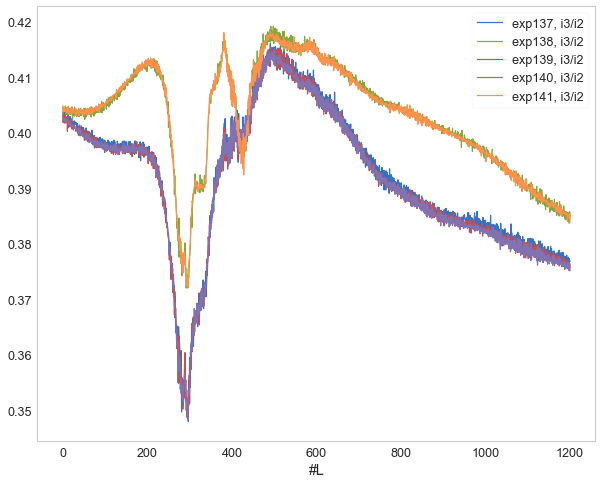

In [417]:
xpC = [load_nexafs_file(i) for i in range(137,142)]
for i,xp in enumerate(xpC[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 137), figsize=(10,8))
plt.legend()

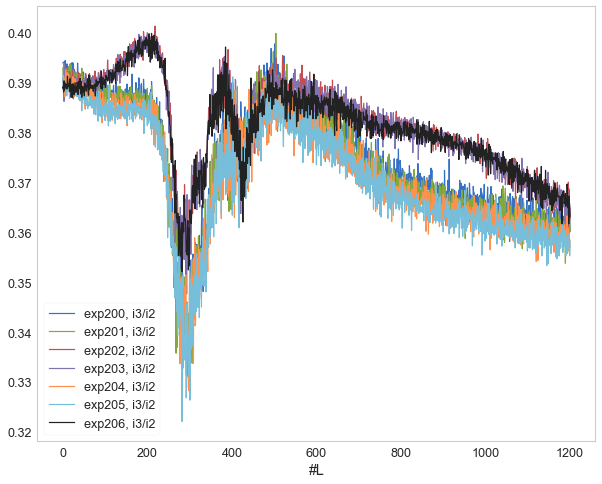

In [63]:
xpCba = [load_nexafs_file(i) for i in range(200,207)]
for i,xp in enumerate(xpCba[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 200), figsize=(10,8))
plt.legend()

In [421]:
(xpC[0].i3/xpC[0].i2).iloc[-1]

0.37683790545545953

In [64]:
(xpCba[0].i3/xpCba[0].i2).iloc[-1]

0.3602737176240077

Text(0.5, 0.98, 'Carbon, NiBr2/NbSe2 (no FBI deposited)')

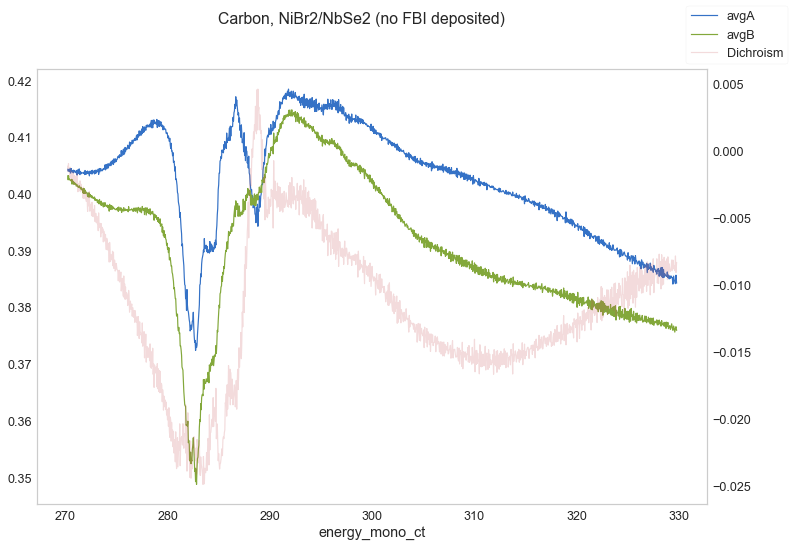

In [61]:
xpC = [load_nexafs_file(i) for i in range(137,142)]
plot_dichroism(xpC, thres=0.38, ithres=-1)
plt.gcf().suptitle('Carbon, NiBr2/NbSe2 (no FBI deposited)')

Text(0.5, 0.98, 'Carbon, NiBr2/NbSe2 (no Ba(ClO4)2 deposited)')

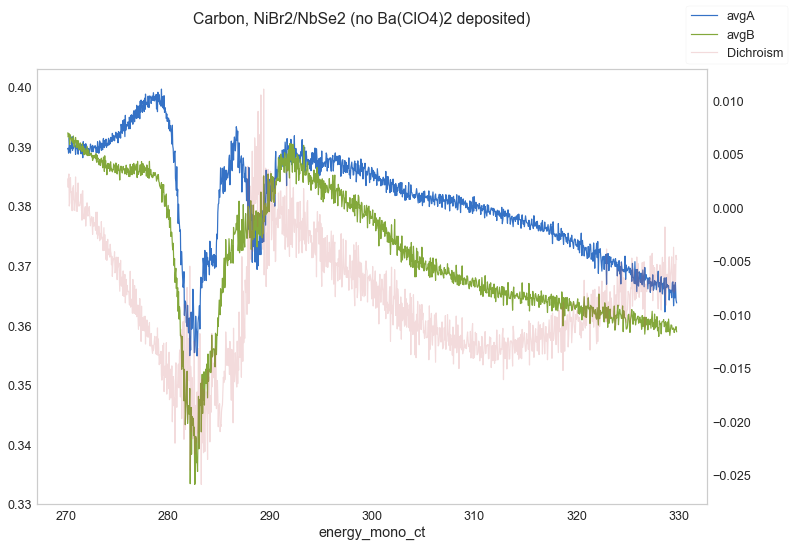

In [65]:
avgA, avgB = plot_dichroism(xpCba, thres=0.39, ithres=200)
plt.gcf().suptitle('Carbon, NiBr2/NbSe2 (no Ba(ClO4)2 deposited)')

In [479]:
avgA.tail(1), avgB.tail(1)

(energy_mono_ct
 329.783616    0.362361
 dtype: float64, energy_mono_ct
 329.783616    0.35766
 dtype: float64)

## N 

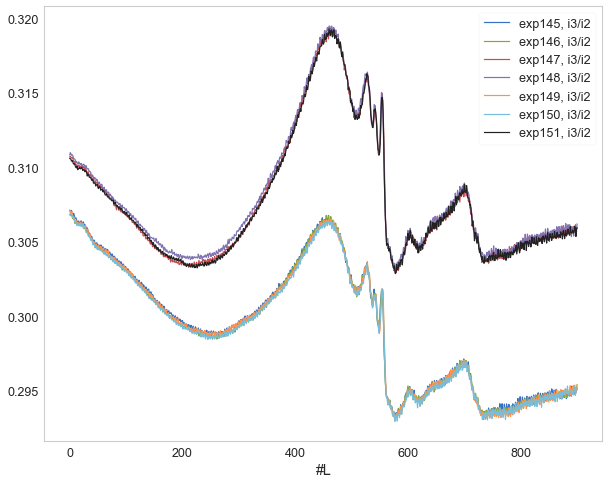

In [429]:
xpN = [load_nexafs_file(i) for i in range(145,152)]
for i,xp in enumerate(xpN[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 145), figsize=(10,8))
plt.legend()

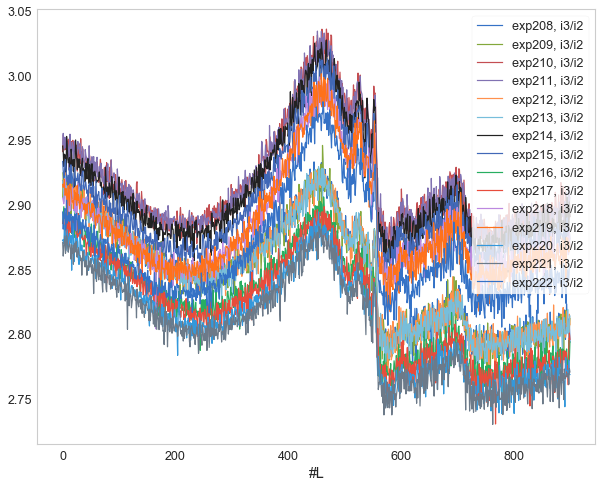

In [488]:
xpNba = [load_nexafs_file(i) for i in range(208,223)]
for i,xp in enumerate(xpNba[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 208), figsize=(10,8))
plt.legend()

Text(0.5, 0.98, 'Nitrogen FBI')

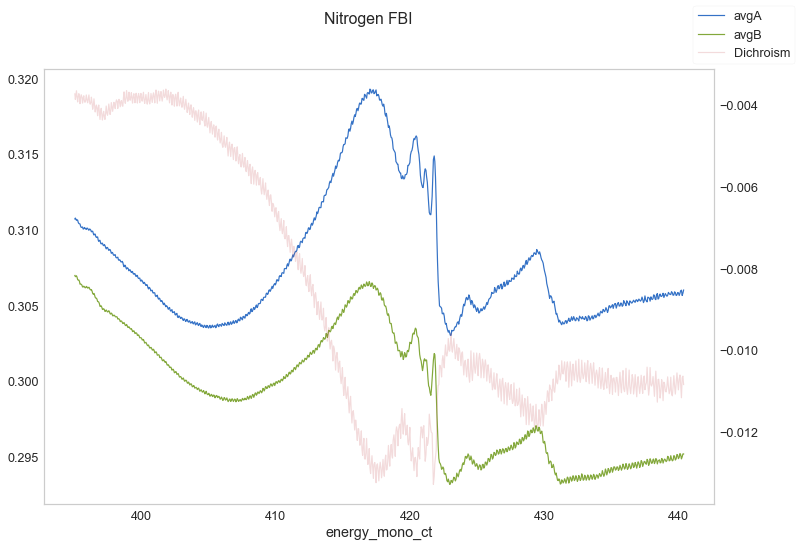

In [492]:
xpN = [load_nexafs_file(i) for i in range(145,152)]
plot_dichroism(xpN, thres=0.309, ithres=0)
plt.gcf().suptitle('Nitrogen FBI')

Text(0.5, 0.98, 'Nitrogen FBI-Ba')

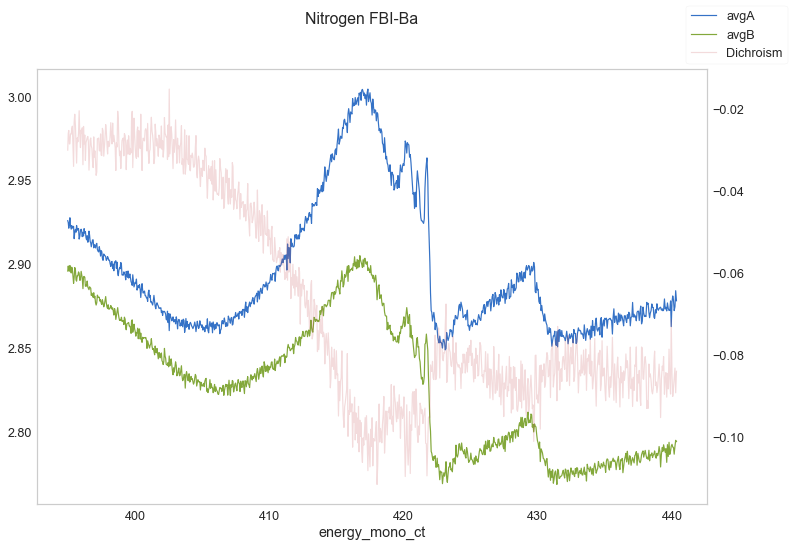

In [496]:
plot_dichroism(xpNba, thres=2.83, ithres=-1)
plt.gcf().suptitle('Nitrogen FBI-Ba')

In [435]:
(xpN[1].i3/xpN[1].i2).iloc[0]

0.4047937068561967

In [430]:
(xpN[0].i3/xpN[0].i2).iloc[0]

0.307081580733804

## Ba

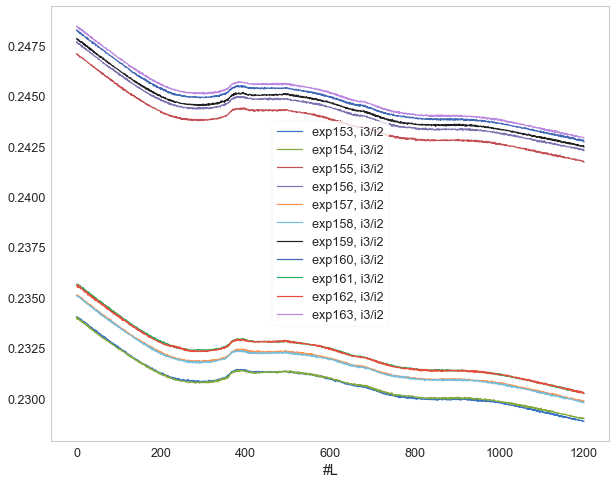

In [499]:
xpBa0 = [load_nexafs_file(i) for i in range(153,164)]
for i,xp in enumerate(xpBa0[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 153), figsize=(10,8))
plt.legend()

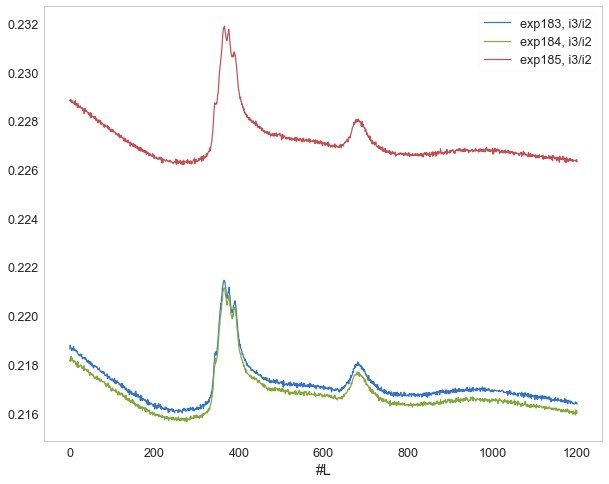

In [497]:
xpbaba = [load_nexafs_file(i) for i in range(183,186)]
for i,xp in enumerate(xpbaba[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 183), figsize=(10,8))
plt.legend()

Text(0.5, 0.98, 'Ba FBI, XLD')

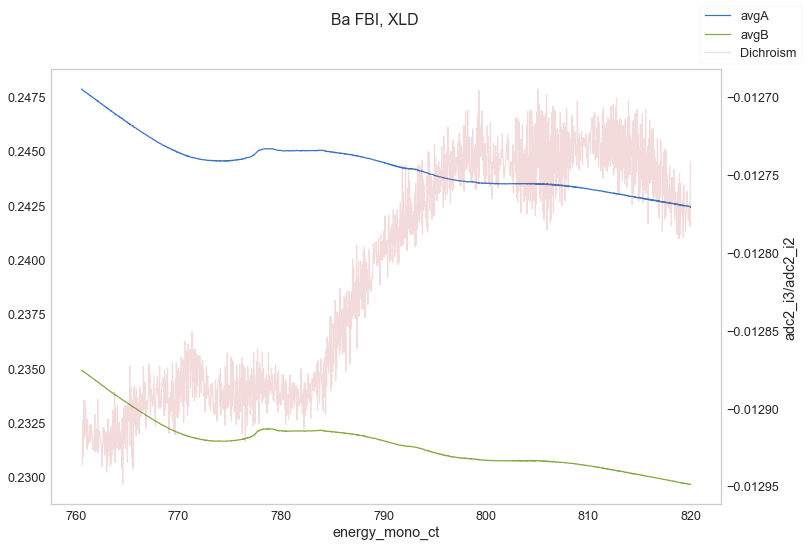

In [504]:
plot_dichroism(xpBa0, thres=0.237, ithres=0)
plt.ylabel('adc2_i3/adc2_i2')
plt.gcf().suptitle('Ba FBI, XLD')

Text(0.5, 0.98, 'Ba FBI-Ba')

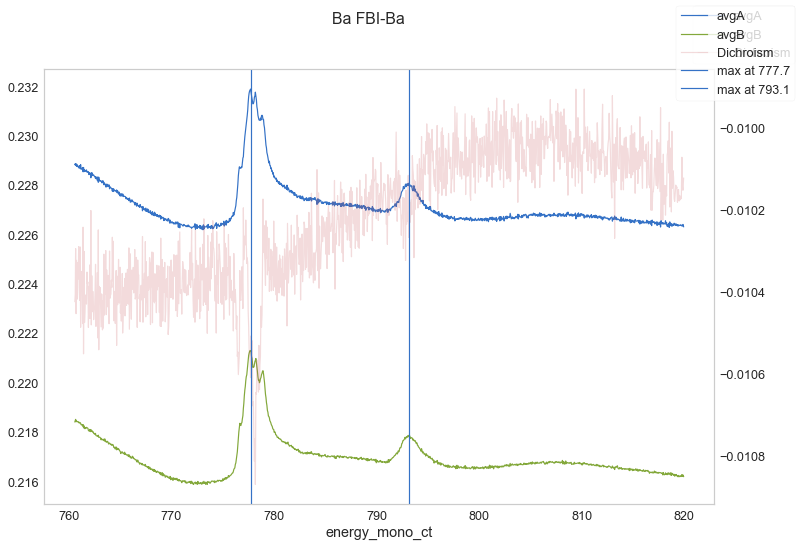

In [565]:
ava, avb = plot_dichroism(xpbaba, thres=0.22, ithres=0)
plt.axvline(ava.idxmax(), label='max at %.1f'%ava.idxmax())

idmax = np.where(ava == ava.max())[0][0]
max2 = ava.iloc[idmax+70:].idxmax()
plt.axvline(max2, label='max at %.1f'%max2)

plt.gcf().legend()
plt.gcf().suptitle('Ba FBI-Ba')

##### For Cobalt

L3M5 (L3) = 776.25

L2M4 (L2) = 791.41

https://physics.nist.gov/PhysRefData/XrayTrans/Html/search.html

##### For Barium

L3M5 (L3) = 780

L2M4 (L2) = 795

https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=(L2%2C%20L3)%2C%20(M4%2C%20M5)%E2%80%A6spectra

In [512]:
ava.idxmax(), avb.idxmax()

(777.714411505, 777.671860185)

In [519]:
idmax = np.where(ava == ava.max())[0][0]

In [533]:
ava.iloc[idmax+70:].idxmax()

793.132305372

# NiBr2/Au

## O

In [18]:
xpO = [load_nexafs_file(i) for i in range(90,93)]
for i,xp in enumerate(xpO[:]):
    try:
        xp.set_index('energy_mono_ct', inplace=True)
    except KeyError:
        xp.set_index('energy_mono_corrected', inplace=True)

In [24]:
xpO[2]

,energy_mono_corrected,ideu71_motor_gap,adc2_timer,i1,i2,i3,i4,timer_mono_ct,grpitch_mono_ct,grenc_mono_ct,dt
energy_mono_ct,,,,,,,,,,,
514.959694,515.00,45325.497430,0.1,-0.233098,-0.530943,-0.264798,-0.001585,0.1,-13354.025125,1901571.0,0.299811
514.989656,515.05,45327.330303,0.1,-0.233334,-0.531622,-0.264995,-0.001556,0.1,-13352.740267,1901518.0,0.399847
515.036585,515.10,45329.163176,0.1,-0.233353,-0.531279,-0.264865,-0.001573,0.1,-13350.728131,1901435.0,0.499883
515.082391,515.15,45330.996049,0.1,-0.233376,-0.530919,-0.264384,-0.001590,0.1,-13348.764480,1901354.0,0.599920
515.126508,515.20,45332.828923,0.1,-0.233660,-0.531703,-0.263832,-0.001568,0.1,-13346.873558,1901276.0,0.699956
515.170067,515.25,45334.661796,0.1,-0.234062,-0.533220,-0.264712,-0.001572,0.1,-13345.006877,1901199.0,0.799992
515.219292,515.30,45336.494669,0.1,-0.234208,-0.533716,-0.265045,-0.001578,0.1,-13342.897771,1901112.0,0.900028
515.265696,515.35,45338.327543,0.1,-0.233966,-0.532827,-0.264099,-0.001583,0.1,-13340.909878,1901030.0,1.000065
515.314374,515.40,45340.160416,0.1,-0.233624,-0.531406,-0.265642,-0.001570,0.1,-13338.825014,1900944.0,1.100101


In [53]:
def plot_dichroism(exps : list, thres : float, ithres : int = 0):
    """Divide files over two polarizations using a hard threshold
    average each, subtract and plot all"""
    A = []
    B = []
    for i,xp in enumerate(exps):
        if (xp.i3/xp.i2).iloc[ithres] > thres:
            A.append(xp.i3/xp.i2)
        else:
            B.append(xp.i3/xp.i2)
    #     (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 125), figsize=(10,8))
    avgA = pd.concat(A, axis=1).mean(axis=1)
    avgB = pd.concat(B, axis=1).mean(axis=1)
    avgA.index = exps[0]['energy_mono_ct']
    avgB.index = exps[0]['energy_mono_ct']

    fig, ax = plt.subplots(figsize=(12,8))
    avgA.plot(ax=ax, label='avgA')
    avgB.plot(ax=ax, label='avgB')

    ax2 = ax.twinx()
    (avgB-avgA).plot(ax=ax2, label='Dichroism', color='r', alpha=0.2)

    fig.legend()
    return avgA, avgB

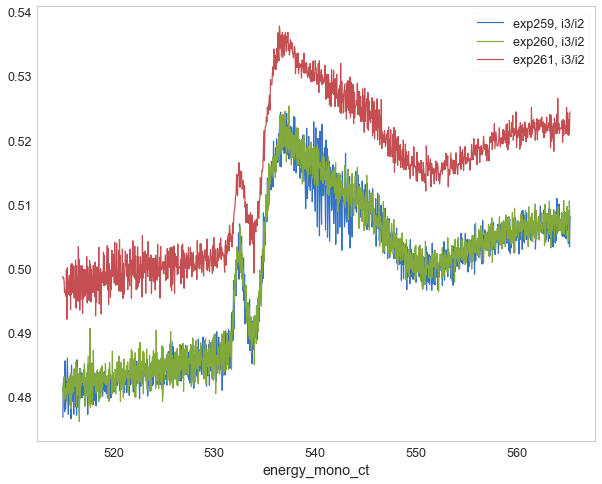

In [20]:
for i,xp in enumerate(xpO[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 90), figsize=(10,8))
plt.legend()

Text(0.5, 0.98, 'O XLD, FBI on NiBr2/Au(111)')

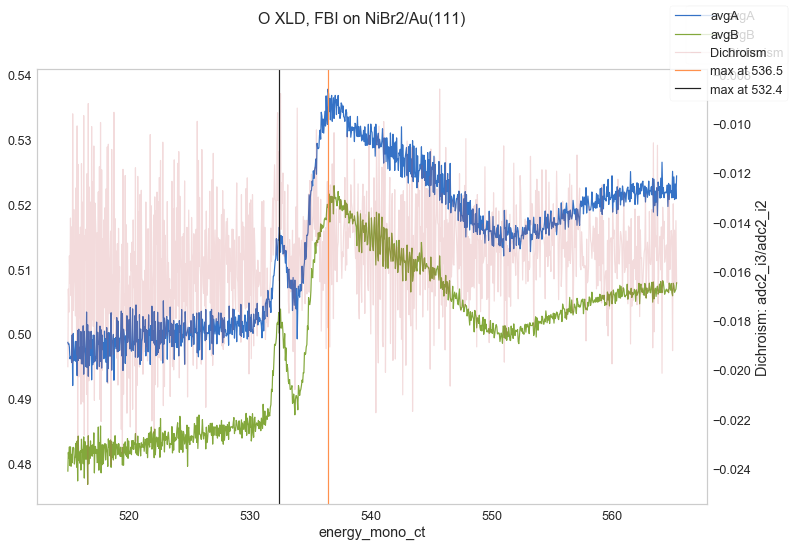

In [69]:
xpO = [load_nexafs_file(i) for i in range(90,93)]
ava, avb = plot_dichroism(xpO, thres=0.49, ithres=0)
plt.ylabel('Dichroism: adc2_i3/adc2_i2')
plt.axvline(ava.idxmax(), label='max at %.1f'%ava.idxmax(), color='y')

idmax = np.where(ava == ava.max())[0][0]
max2 = ava.iloc[:idmax-70].idxmax()
plt.axvline(max2, label='max at %.1f'%max2, color='k')

plt.gcf().legend()
plt.gcf().suptitle('O XLD, FBI on NiBr2/Au(111)')

## C

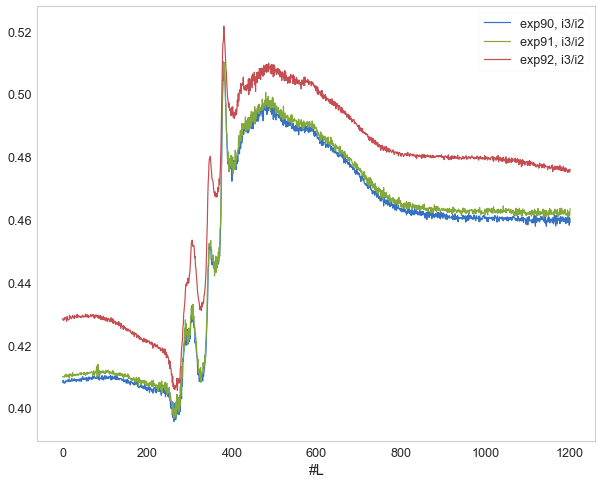

In [59]:
xpC = [load_nexafs_file(i) for i in range(104,107)] 
for i,xp in enumerate(xpC[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 90), figsize=(10,8))
plt.legend()

Text(0.5, 0.98, 'Carbon XLD, FBI on NiBr2/Au(111)')

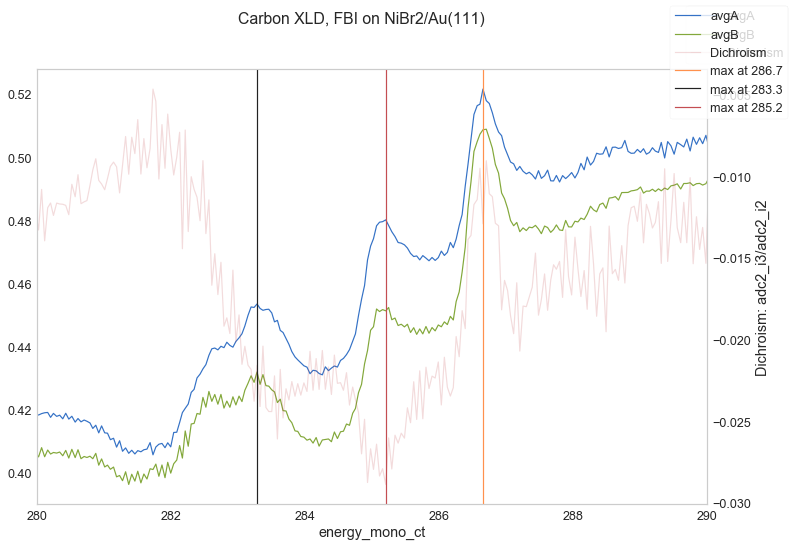

In [98]:
xpC = [load_nexafs_file(i) for i in range(104,107)]
ava, avb = plot_dichroism(xpC, thres=0.42, ithres=0)
plt.ylabel('Dichroism: adc2_i3/adc2_i2')

plt.axvline(ava.idxmax(), label='max at %.1f'%ava.idxmax(), color='y')

idmax = np.where(ava == ava.max())[0][0]

max3 = ava.iloc[:idmax-70].idxmax()
plt.axvline(max3, label='max at %.1f'%max3, color='k')
idmax3 = np.where(ava == ava[max3])[0][0]

max2 = ava.iloc[idmax3+8:idmax-25].idxmax()
plt.axvline(max2, label='max at %.1f'%max2, color='r')

plt.xlim(280, 290)
plt.gcf().legend()
plt.gcf().suptitle('Carbon XLD, FBI on NiBr2/Au(111)')

In [82]:
np.where(ava == max3)
ava[max3]

0.453480772193714

## Ba

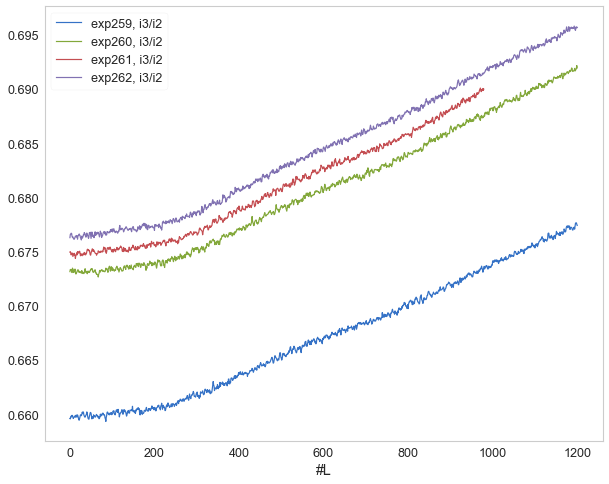

In [505]:
xpBa0 = [load_nexafs_file(i) for i in range(259,263)]
for i,xp in enumerate(xpBa0[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 259), figsize=(10,8))
plt.legend()

Text(0.5, 0.98, 'Ba FBI (NiBr2/Au(111), XLD')

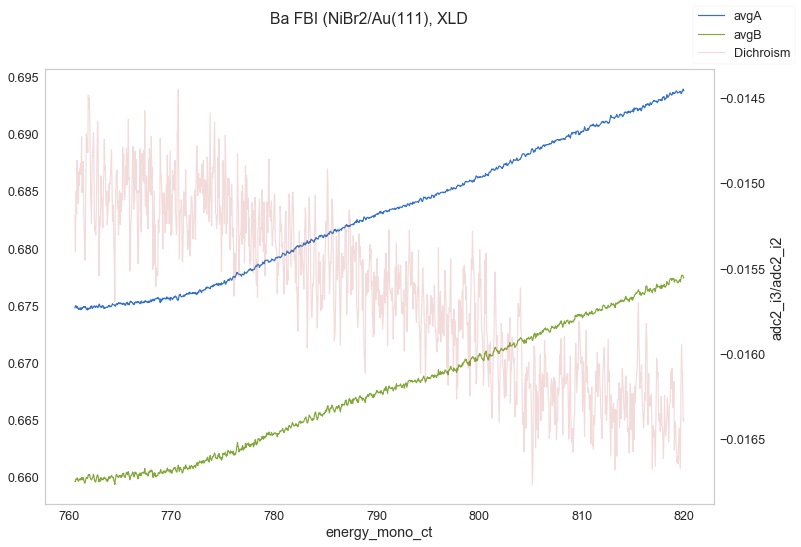

In [507]:
plot_dichroism(xpBa0, thres=0.662, ithres=0)
plt.ylabel('adc2_i3/adc2_i2')
plt.gcf().suptitle('Ba FBI (NiBr2/Au(111), XLD')

## N

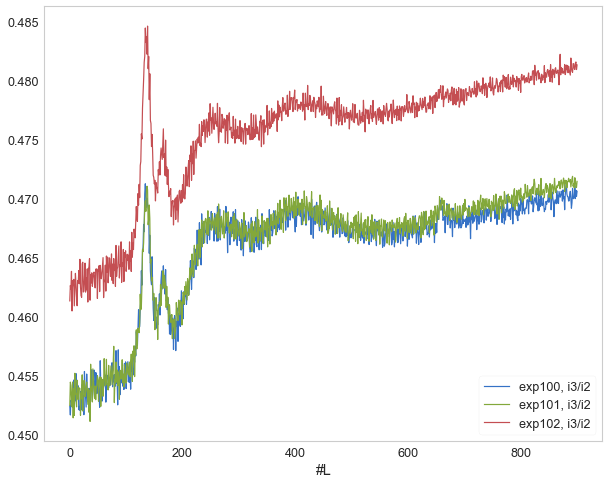

In [90]:
xpNfbi = [load_nexafs_file(i) for i in range(100,103)]
for i,xp in enumerate(xpNfbi[:]):
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 100), figsize=(10,8))
plt.legend()

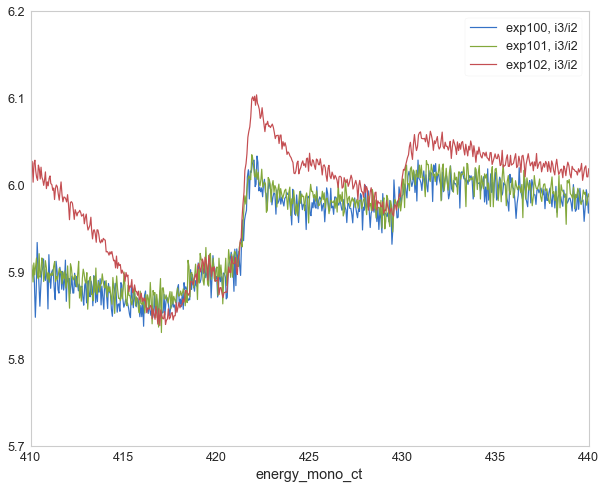

In [560]:
xpNba = [load_nexafs_file(i) for i in range(288,291)]
for i,xp in enumerate(xpNba[:]):
    xp.set_index('energy_mono_ct', inplace=True)
    (xp.i3/xp.i2).plot(label='exp%i, i3/i2' %(i + 100), figsize=(10,8))
    plt.xlim(410,440)
    plt.ylim(5.7,6.2)
plt.legend()

In [550]:
(xpNba[0].i3/xpNba[0].i2).tail(1)

energy_mono_ct
440.373373    5.979494
dtype: float64

In [554]:
(xpNba[2].i3/xpNba[2].i2).tail(1)

energy_mono_ct
440.345258    6.012376
dtype: float64

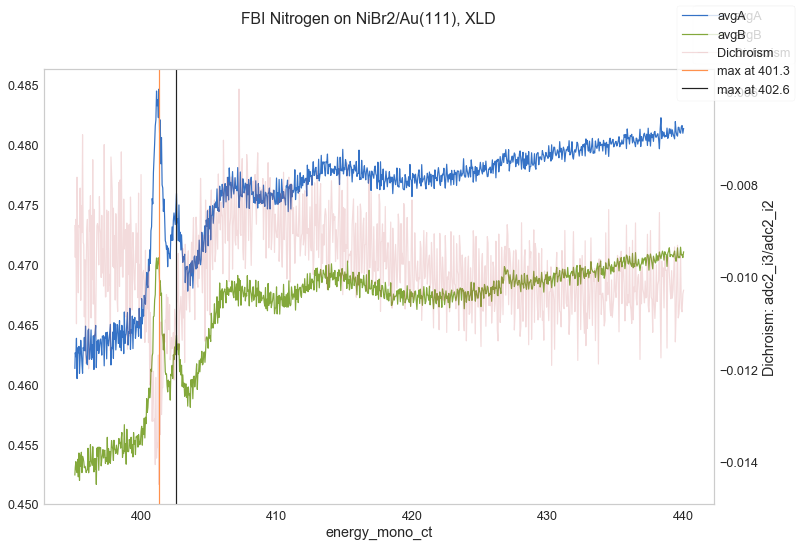

In [97]:
ava, avb = plot_dichroism(xpNfbi, thres=0.455, ithres=0)

plt.gcf().suptitle('FBI Nitrogen on NiBr2/Au(111), XLD')

plt.ylabel('Dichroism: adc2_i3/adc2_i2')
plt.axvline(ava.idxmax(), label='max at %.1f'%ava.idxmax(), color='y')

idmax = np.where(ava == ava.max())[0][0]
max2 = ava.iloc[idmax+15:idmax+50].idxmax()
plt.axvline(max2, label='max at %.1f'%max2, color='k')

plt.gcf().legend()

(410, 440)

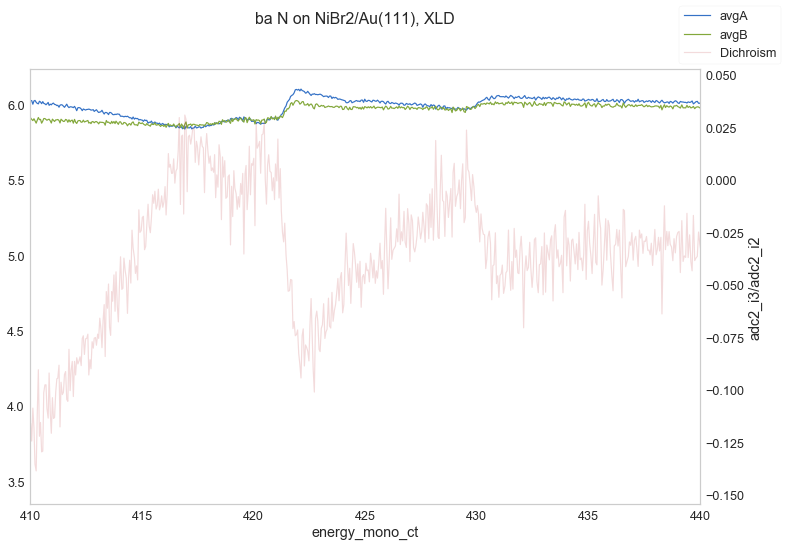

In [563]:
xpNba = [load_nexafs_file(i) for i in range(288,291)]
plot_dichroism(xpNba, thres=5.99, ithres=-1)
plt.ylabel('adc2_i3/adc2_i2')
plt.gcf().suptitle('ba N on NiBr2/Au(111), XLD')
plt.xlim(410,440)